In [38]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

class VectorFlowAutomaton:
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.grid_vectors = np.zeros((height, width, 2), dtype=float)
        self.visualization_vectors = np.zeros((height, width, 2), dtype=float)
        self.obstacles = np.zeros((height, width), dtype=bool)
        
        self.flow_directions = np.array([
            [1, 0], [0.5, np.sqrt(3)/2], [-0.5, np.sqrt(3)/2],
            [-1, 0], [-0.5, -np.sqrt(3)/2], [0.5, -np.sqrt(3)/2]
        ])

    def add_obstacle_box(self, x, y, size_x, size_y):
        self.obstacles[y:y+size_y, x:x+size_x] = True
        self.grid_vectors[self.obstacles] = 0

    def set_inflow_source(self, y_start, y_end, vector):
        self.source_y = (y_start, y_end)
        self.source_vector = np.array(vector)
        self.grid_vectors[y_start:y_end, 0] = self.source_vector

    def _get_hex_neighbors(self, r, c):
        """
        Calcula as coordenadas dos 6 vizinhos em uma grade hexagonal 
        organizada horizontalmente (pointy-top).
        """
        neighbors = []
        if r % 2 == 0:  # Linha Par
            candidate_neighbors = [
                (r, c + 1), (r, c - 1), (r - 1, c - 1), 
                (r - 1, c), (r + 1, c - 1), (r + 1, c)
            ]
        else:  # Linha Ímpar
            candidate_neighbors = [
                (r, c + 1), (r, c - 1), (r - 1, c), 
                (r - 1, c + 1), (r + 1, c), (r + 1, c + 1)
            ]
        for nr, nc in candidate_neighbors:
            if 0 <= nr < self.height and 0 <= nc < self.width:
                neighbors.append((nr, nc))
        return neighbors

    def step(self):
        """Executa um passo da simulação com a lógica de vizinhos corrigida."""
        new_vectors = self.grid_vectors.copy()
        for r in range(self.height):
            for c in range(self.width):
                if self.obstacles[r, c]:
                    continue
                vectors_to_average = [self.grid_vectors[r, c]]
                neighbor_coords = self._get_hex_neighbors(r, c)
                for nr, nc in neighbor_coords:
                    if not self.obstacles[nr, nc]:
                        vectors_to_average.append(self.grid_vectors[nr, nc])
                if vectors_to_average:
                    mean_vector = np.mean(vectors_to_average, axis=0)
                    self.visualization_vectors[r, c] = mean_vector
                    if np.any(mean_vector):
                        dot_products = np.dot(self.flow_directions, mean_vector)
                        best_dir_idx = np.argmax(dot_products)
                        new_vectors[r, c] = self.flow_directions[best_dir_idx]
                    else:
                        new_vectors[r, c] = [0, 0]
        if hasattr(self, 'source_y'):
            y_start, y_end = self.source_y
            new_vectors[y_start:y_end, 0] = self.source_vector
        self.grid_vectors = new_vectors
        
    def run_simulation(self, steps, filename="flow_simulation.gif"):
        """Roda a simulação e salva como GIF."""
        fig, ax = plt.subplots(figsize=(12, 6))
        def update(frame):
            ax.clear()
            obstacle_map = np.ma.masked_where(~self.obstacles, np.ones_like(self.obstacles))
            ax.imshow(obstacle_map, cmap='binary', origin='upper', extent=[-0.5, self.width-0.5, self.height-0.5, -0.5], zorder=1)
            X, Y = np.meshgrid(np.arange(self.width), np.arange(self.height))
            U, V = self.grid_vectors[:, :, 0], self.grid_vectors[:, :, 1]
            mask = (U**2 + V**2) > 0.01
            ax.quiver(X[mask], Y[mask], U[mask], V[mask], color='deepskyblue', 
                        angles='xy', scale_units='xy', scale=1, 
                        headwidth=5, headlength=7, zorder=2)
            ax.set_title(f'Simulação de Fluxo Vetorial - Passo {frame}')
            ax.set_aspect('equal')
            ax.invert_yaxis()
            ax.set_xlim(-1, self.width)
            ax.set_ylim(self.height, -1)
            plt.axis('off')
            if frame > 0:
                self.step()
        ani = animation.FuncAnimation(fig, update, frames=steps, interval=100, repeat=False)
        ani.save(filename, writer='pillow')
        plt.close()
        print(f"Animação salva como '{filename}'")

In [40]:
automaton = VectorFlowAutomaton(width=80, height=40)

# Adicionando obstáculos
automaton.add_obstacle_box(20, 0, 5, 18)
automaton.add_obstacle_box(20, 24, 5, 18)
automaton.add_obstacle_box(50, 10, 5, 20)

# Definindo a fonte de fluxo na borda esquerda
automaton.set_inflow_source(y_start=0, y_end=1, vector=[1, 0]) # Fluxo para a direita

# Rodando e salvando a simulação
automaton.run_simulation(steps=120)

Animação salva como 'flow_simulation.gif'


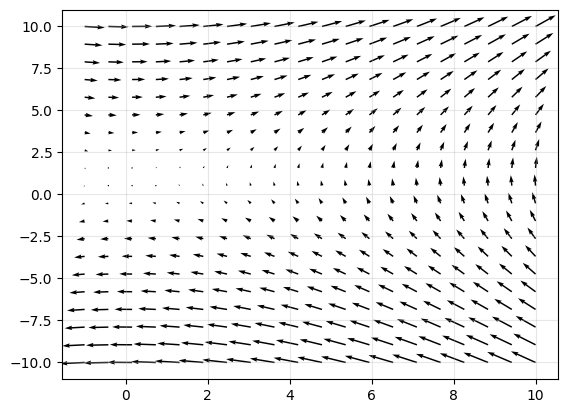

In [37]:
import numpy as np
import matplotlib.pyplot as plt

x,y = np.meshgrid(np.linspace(-1,10,20), np.linspace(-10,10,20))
u = y-1
v = x/2

plt.quiver(x,y,u,v)
plt.grid(alpha=0.3)
plt.show()

# Real Oficial handmade celular automata river

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

class WaterParticle:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.vectordirection = 0x00000000
        self.flow_directions = np.array([
            [1, 0],                    # Direita
            [0.5, np.sqrt(3)/2],       # Superior-Direita
            [-0.5, np.sqrt(3)/2],      # Superior-Esquerda
            [-1, 0],                   # Esquerda
            [-0.5, -np.sqrt(3)/2],     # Inferior-Esquerda
            [0.5, -np.sqrt(3)/2]       # Inferior-Direita
        ])

    # Adiciona o safety check for neighbors
    def get_neighbors_vector(self):
        neighbors = []
        for dx, dy in self.flow_directions:
            neighbor = (self.x + dx, self.y + dy)
            if 0 <= neighbor[0] < self.width and 0 <= neighbor[1] < self.height:
                neighbors.append(neighbor)
        return neighbors

    def recalculate_direction(self):
        neighbors = self.get_neighbors_vector()
        if neighbors:
            mean_vector = np.mean(neighbors, axis=0)
            dot_products = np.dot(self.flow_directions, mean_vector)
            best_dir_idx = np.argmax(dot_products)
            self.vectordirection = self.flow_directions[best_dir_idx]
        else:
            self.vectordirection = self.vectordirection
        
        
    def apply_collision_rules(self, vectordirection):
        COLLISION_RULES = {
            52:25,
            25:52,
            50:41,
            41:50,
            22:13,
            13:22,
            26:44,
            44:26,
            38:11,
            11:38,
            37:19,
            26:44,
            42:21,
            21:42,
            27:45,
            45:54,
            54:27,
            36:18,
            18:9,
            9:36
        }
        return COLLISION_RULES[vectordirection]


class RiverFlowSimulation:
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.grid = np.zeros((height, width), dtype=int)
        self.obstacles = np.zeros((height, width), dtype=bool)
        
    def add_obstacle_box(self, x, y, size_x, size_y):
        self.obstacles[y:y+size_y, x:x+size_x] = True
        self.grid[self.obstacles] = 0
        
    def add_water_particle(self, x, y):
        if 0 <= x < self.width and 0 <= y < self.height and not self.obstacles[y, x]:
            self.grid[y, x] = WaterParticle(x, y)
    
    def step(self):
        for r in range(self.height):
            for c in range(self.width):
                if self.obstacles[r, c] or not isinstance(self.grid[r, c], WaterParticle):
                    